# Implementing Decision Trees from Scratch #
    - Matt Robinson
    
The code here is loosely based on the code found in Jason Brownlee's [nice tutorial](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/). However, I have made significant changes. Most notably, I have made my code class based to closely resemble the format of the scikit-learn tree class.

In [150]:
# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [151]:
# get the Iris dataset from seaborn
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [152]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:4].values, df.iloc[:, 4].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [166]:
class DecisionTree(object):
    
    def __init__(self, max_depth=2, min_samples_split=0, min_samples_leaf=0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        
        self.root_node_ = None
        
        self.root_node_ = get_split(X,y)
        split(self.root_node_, depth=0)
            
        return self
    
    def _get_gini_score(self, X, y):
        N = X.shape[0]

        gini_score = 1
        for class_i in np.unique(y):
            Ni = X[y==class_i].shape[0]
            gini_score -= (Ni/N)**2

        return gini_score   
    
    def _split_classes_in_two(self, X, y, sample_idx, feature_idx):
        value_to_split_on = X[sample_idx,feature_idx]

        left_idx = X[:,0] <= value_to_split_on
        left_X = X[left_idx]
        left_y = y[left_idx]

        right_idx = X[:,0] > value_to_split_on
        right_X = X[right_idx]
        right_y = y[right_idx]

        return left_X, left_y, right_X, right_y
    
    
    def _get_split_value(self, X, y):
        '''Select the best split point for a dataset'''

        N = X.shape[0]
        num_features = X.shape[1]

        best_gini_cost = gini(X,y)
        found_split = False

        for j in range(num_features):
            for i in range(N):
                # this is really simplistic
                # just iterate over every feature value
                # for every sample, and see what produces
                # the best split of left and right
                # in terms of Gini impurity
                lX,ly,rX,ry = self._split_classes_in_two(X, y, sample_idx=i, feature_idx=j)
                left_gini = self._get_gini_score(lX,ly)
                right_gini = seff._get_gini_score(rX,ry)

                gini_cost = (len(lX)/N)*left_gini + (len(rX)/N)*right_gini
                if (gini_cost < best_gini_cost) and \
                    (len(lX) >= self.min_samples_leaf) and \
                    (len(rX) >= self.min_samples_leaf):

                    found_split = True
                    best_gini_cost = gini_cost
                    best_gini_feature_idx = j
                    best_gini_feature_value = X[i,j]
                    best_lX, best_ly = lX,ly
                    best_rX, best_ry = rX,ry

        if found_split:
            return {"feature_idx": best_gini_feature_idx, 
                    "feature_value": best_gini_feature_value, 
                    "left": [best_lX, best_ly],
                    "right": [best_rX, best_ry]}
        else:
            return {"leaf": [X,y]}
        
    def _split_node(self, node, depth):
    
        if "leaf" in node:
            return

        lX,ly = node['left'][:]
        rX,ry = node['right'][:]

        # get rid of old info
        del(node['left'])
        del(node['right'])

        if depth >= self.max_depth-1:
            node["left"] = {"leaf": [lX,ly]}
            node["right"] = {"leaf": [rX,ry]}
            return

        if (len(lX) < self.min_samples_split) and (len(rX) < self.min_samples_split):
            node["left"] = {"leaf": [lX,ly]}
            node["right"] = {"leaf": [rX,ry]}
            return

        elif (len(lX) < self.min_samples_split) and (len(rX) >= self.min_samples_split):
            node["left"] = {"leaf": [lX,ly]}
            node["right"] = self._get_split_value(rX,rY)
            self._split_node(node["right"], depth+1)

        elif (len(lX) >= self.min_samples_split) and (len(rX) < self.min_samples_split):
            node["right"] = {"leaf": [rX,ry]}
            node["left"] = self._get_split_value(lX,lY)
            self._split_node(node["left"], depth+1)

        else:
            node["left"] = self._get_split_value(lX,ly)
            self._split_node(node["left"], depth+1)

            node["right"] = self._get_split_value(rX,ry)
            self._split_node(node["right"], depth+1)
            
    def _predict_sample(self, node, X_row):
        '''
        Note here that X_row is just one row of the design matrix
        '''
        # if leaf, then predict based 
        # on most popular class in leaf
        if "leaf" in node:
            leaf_X, leaf_y = node["leaf"][:]
            unique_targets, counts = np.unique(leaf_y, return_counts=True)
            # get most popular class in leaf
            prediction = [x[1] for x in sorted(zip(counts,unique_targets),reverse=True)][0]
            return prediction

        elif X_row[node['feature_idx']] <= node['feature_value']:
            return self._predict_sample(node["left"], X_row)

        elif X_row[node['feature_idx']] > node['feature_value']:
            return self._predict_sample(node["right"], X_row)
        
    def predict(self, X):
        predicted_y = []
        for sample in X:
            predicted_y.append(
                self._predict_sample(self.root_node_, sample)
            )
        return np.array(predicted_y)
            

In [167]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [168]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)


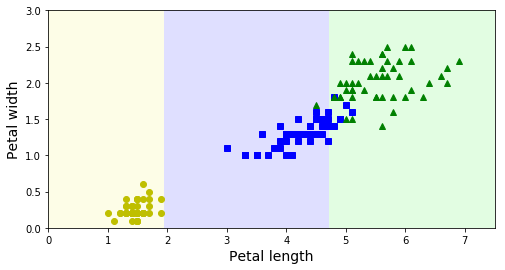

In [169]:
my_tree_clf = DecisionTree(max_depth=7)
my_tree_clf.fit(X, y)

plt.figure(figsize=(8, 4))
plot_decision_boundary(my_tree_clf, X, y)

Obviously, there is some work to be done on where the boundary is drawn, which will probably rely on presorting of the data. But at least we got something that kind of works and is interesting.